In [19]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [67]:
import torch
import torch.nn.functional as F
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from vocoders.hifigan_model import load_hifigan_generator
import os
import soundfile as sf


In [68]:
class InterpLnr(torch.nn.Module):
    
    def __init__(self):
        super().__init__()        
        
    def pad_sequences(self, sequences):
        channel_dim = sequences[0].size()[-1]
        out_dims = (len(sequences), self.max_len_pad, channel_dim)
        out_tensor = sequences[0].data.new(*out_dims).fill_(0)
        
        for i, tensor in enumerate(sequences):
            length = tensor.size(0)
            out_tensor[i, :length, :] = tensor[:self.max_len_pad]
            
        return out_tensor 
    

    def forward(self, x):

        device = x.device
        batch_size = x.size(0)

        #self.max_len_seq = 1#config.max_len_seq
        self.max_len_seq = x.size(1)
        self.max_len_pad = self.max_len_seq #192#config.max_len_pad
        
        self.min_len_seg = 19 #config.min_len_seg
        self.max_len_seg = 48 #config.max_len_seg
        
        self.max_num_seg = self.max_len_seq // self.min_len_seg + 1
        

        #print(x.device)
        #len_seq = torch.tensor([x.size(1)]).to(x.device)
        len_seq = torch.tensor(self.max_len_pad).expand(batch_size).to(device)
        #print(len_seq)

        
        
        # indices of each sub segment
        indices = torch.arange(self.max_len_seg*2, device=device)\
                  .unsqueeze(0).expand(batch_size*self.max_num_seg, -1)
        # scales of each sub segment
        scales = torch.rand(batch_size*self.max_num_seg, 
                            device=device) + 0.5
        
        idx_scaled = indices / scales.unsqueeze(-1)
        idx_scaled_fl = torch.floor(idx_scaled)
        lambda_ = idx_scaled - idx_scaled_fl
        
        len_seg = torch.randint(low=self.min_len_seg, 
                                high=self.max_len_seg, 
                                size=(batch_size*self.max_num_seg,1),
                                device=device)
        
        # end point of each segment
        idx_mask = idx_scaled_fl < (len_seg - 1)
       
        offset = len_seg.view(batch_size, -1).cumsum(dim=-1)
        # offset starts from the 2nd segment
        offset = F.pad(offset[:, :-1], (1,0), value=0).view(-1, 1)
        
        idx_scaled_org = idx_scaled_fl + offset
        
        len_seq_rp = torch.repeat_interleave(len_seq, self.max_num_seg)

        # print(idx_scaled_org.device)
        # print(len_seq_rp.device)
        # print(len_seq.device)
        idx_mask_org = idx_scaled_org < (len_seq_rp - 1).unsqueeze(-1)
        
        idx_mask_final = idx_mask & idx_mask_org
        
        counts = idx_mask_final.sum(dim=-1).view(batch_size, -1).sum(dim=-1)
        
        index_1 = torch.repeat_interleave(torch.arange(batch_size, 
                                            device=device), counts)
        
        index_2_fl = idx_scaled_org[idx_mask_final].long()
        index_2_cl = index_2_fl + 1
        
        y_fl = x[index_1, index_2_fl, :]
        y_cl = x[index_1, index_2_cl, :]
        lambda_f = lambda_[idx_mask_final].unsqueeze(-1)
        
        y = (1-lambda_f)*y_fl + lambda_f*y_cl
        
        sequences = torch.split(y, counts.tolist(), dim=0)

        print(sequences[0].size())
       
        seq_padded = self.pad_sequences(sequences)

        #print(seq_padded.size())
        return seq_padded

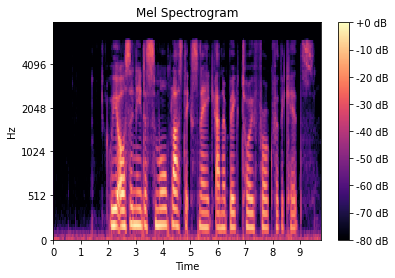

In [69]:
wav_path = '/mnt/data1/waris/datasets/vctk_subset/p229/wav/p229_004_mic1.wav'

y, sr = librosa.load(wav_path)

mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, win_length=1024, hop_length=240, n_mels=80)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

# spec = np.abs(librosa.stft(y, hop_length=512))
# spec = librosa.amplitude_to_db(spec, ref=np.max)
# librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
# plt.colorbar(format='%+2.0f dB');
# plt.title('Spectrogram');

In [70]:
mel_spect = torch.FloatTensor(mel_spect).T.unsqueeze(0)
mel_spect.shape

torch.Size([1, 422, 80])

In [74]:
device = "cuda"
    
interplnr = InterpLnr()
interplnr.to(torch.device("cuda"))

mel_rr = interplnr(mel_spect)
#mel_rr = mel_rr.squeeze(0).T.cpu().numpy()
mel_rr.shape

torch.Size([446, 80])


torch.Size([1, 422, 80])

In [72]:
librosa.display.specshow(mel_rr, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

TypeError: data type not understood

In [80]:
device = 'cuda'
hifigan_model = load_hifigan_generator(device)

#mel_rr = mel_rr.unsqueeze(0)
mel_rr.to(torch.device(device))
y = hifigan_model(mel_rr.view(1, -1, 80).transpose(1, 2))


output_dir = os.path.join('/mnt/data1/waris/repo/transformer-prosody-vc/synthesis_output/temp',)
os.makedirs(output_dir, exist_ok=True)

wav_fname = f"{output_dir}/1.wav"

sf.write(wav_fname, y.squeeze().detach().cpu().numpy(), 24000, "PCM_16")

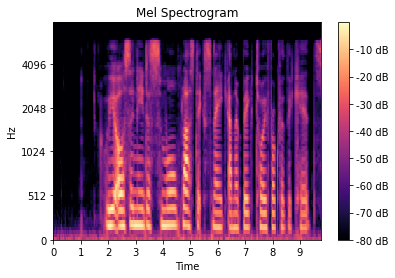

In [81]:
mel_rr = mel_rr.squeeze(0).T.cpu().numpy()
librosa.display.specshow(mel_rr, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

In [ ]:
bnf = '/mnt/data1/waris/datasets/data/arctic_dataset/all_data_for_ac_vc_train/SV2TTS/synthesizer/ppgs/ppg-ABA-arctic_a0004.npy'
embed = '/mnt/data1/waris/model_preprocessing/transformer-vc/dvec/GE2E_spkEmbed_step_5805000/ABA/arctic_a0004.npy'

